# Site selection for circular construction hubs in the Netherlands
We will do a first try with one type of hub - local material bank. Spatial requirements can be found [here](https://docs.google.com/spreadsheets/d/1K64-si25n3VcUpwUGZtCrVd19Mx5G7FYg1fkyM8eZwI/edit#gid=904357013). The steps for this study will be: 
* **data collection**: collecting relevant data (humans, material, company locations) 
* **data wrangling**: harmonizing data to fit the same format (either postcodes or a grid of certain size) 
* **site selection**: select suitable areas according to spatial parameters 
* **facility location**: find locations for facilities using facility location methods 

In [1]:
# import momepy
import pandas as pd
import geopandas as gpd
# import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
pd.options.mode.chained_assignment = None  # default='warn'

# industrial land data - ibis
columns of interest: 
* `HA_BRUTO` - bruto oppervlak (ha) - Gross area (in ha) of the work site
* `PLAN_FASE` - Planfase - planning phase
* `MN_VPRIJS`, `MX_VPRIJS` - gebruik van minimum en maximum verkoopprijs - use of minimum and maximum selling price
* `MN_EPRIJS`, `MX_EPRIJS` - gebruik van minimum en maximum efpachtprijs - use of minimum and maximum leasehold price
* `MILIEUZONE` - milieuzonering - environmental zoning
* `WLOC_TYPE` - type werklocatie - type of work location
* `MAX_MILIEU` - maximale milieucategorie - maximum environmental category

### formatting

In [2]:
ibisFile = gpd.read_file('../_bigData/Ibis 2021/ibis2021_fixed.shp')

In [3]:
ibis = ibisFile[['RIN_NUMMER', 'HA_BRUTO', 'PLAN_FASE','MX_VPRIJS', # MX_VPRIJS was chosen for most non-zero values
                 'MILIEUZONE', 'WLOC_TYPE', 'MAX_MILIEU', 'geometry']] 
ibis = ibis[ibis.MAX_MILIEU != 'X']
ibis.MAX_MILIEU = ibis.MAX_MILIEU.map(lambda x: int(x))
ibis = ibis[(ibis.MAX_MILIEU == 2) | (ibis.MAX_MILIEU == 3)]
ibis.geometry = ibis.geometry.centroid
# ibis.to_file("../_bigData/Ibis 2021/ibis2021_maxMilieu_2-3.shp")

### estimating land prices with spatial interpolation
https://pygis.io/docs/e_interpolation.html#thiessen-polygons-voronoi-diagrams

<AxesSubplot: >

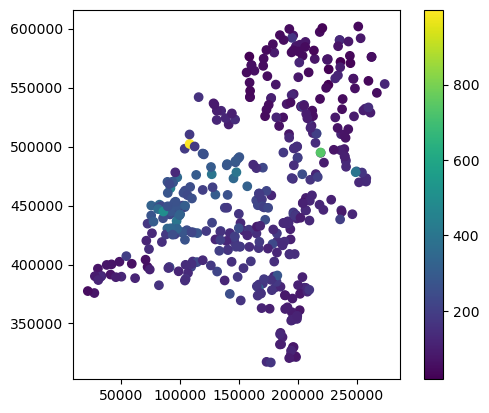

In [8]:
ibis[ibis.MX_VPRIJS > 0].plot(column=ibis[ibis.MX_VPRIJS > 0].MX_VPRIJS, legend=True)

21% of plots have known prices


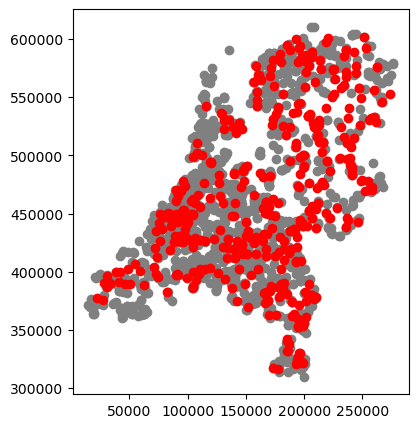

In [9]:
ax = ibis[ibis.MX_VPRIJS == 0].plot(color='grey', figsize=(5,5))
ibis[ibis.MX_VPRIJS > 0].plot(color='red', ax=ax)
percKnown = len(ibis[ibis.MX_VPRIJS > 0]) / len(ibis) * 100
print('{}% of plots have known prices'.format(round(percKnown)))

In [10]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

Comparing my data to the tutorial data, I don't see any major differences. 

In [29]:
# load data 
nl = gpd.read_file('../_bigData/nlMaps/nl_pc2_amersfoort.shp')
landPrice = ibis[ibis.MX_VPRIJS > 0][['RIN_NUMMER', 'MAX_MILIEU', 'MX_VPRIJS', 'geometry']]

In [30]:
# load tutorial data
counties = gpd.read_file("tutorials/data/sf_bay_counties.shp")
rainfall = gpd.read_file("tutorials/data/sf_bay_rainfall.shp")
proj = "+proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs "
counties = counties.to_crs(proj)
rainfall = rainfall.to_crs(proj)

The differences between rainfall and landPrice are as follows: 
* the rainfall data is much more continuous, whereas the landPrice data is more extreme
* the landPrice data has a larger range, from 1-1000, whereas the rainfall ranges between 20-80 

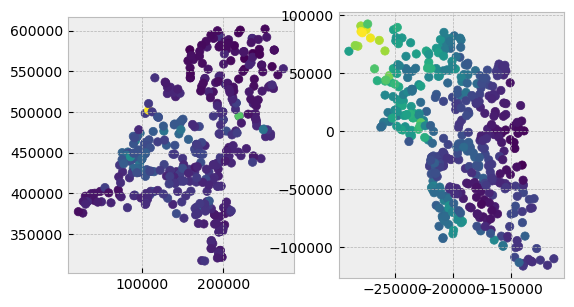

In [31]:
fig, ax = plt.subplots(1,2)
landPrice.plot(column='MX_VPRIJS', ax=ax[0])
rainfall.plot(column='VALUE', ax=ax[1])
plt.show()

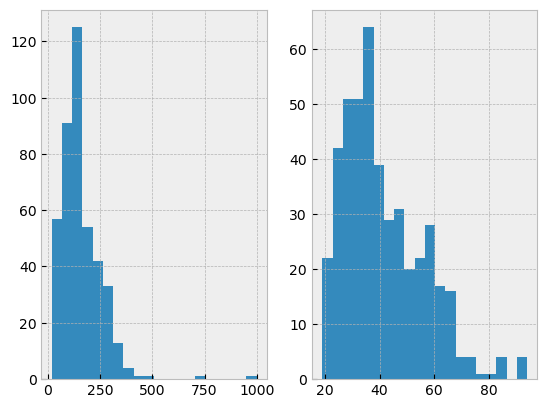

In [32]:
fig, ax = plt.subplots(1,2)
ax[0].hist(landPrice.MX_VPRIJS, bins = 20)
ax[1].hist(rainfall.VALUE, bins = 20)
plt.show()

In [33]:
# Get X and Y coordinates of rainfall points
x_landPrice = landPrice["geometry"].x
y_landPrice = landPrice["geometry"].y

# Create list of XY coordinate pairs
coords_landPrice = [list(xy) for xy in zip(x_landPrice, y_landPrice)]

# Get extent of counties feature
# min_x_counties, min_y_counties, max_x_counties, max_y_counties = counties.total_bounds

# Get list of rainfall "values"
value_landPrice = list(landPrice["MX_VPRIJS"])

# Dissolve all counties to create one polygon
# counties_dissolved = counties.copy()
# counties_dissolved["constant"] = 1
# counties_dissolved = counties_dissolved.dissolve(by = "constant").reset_index(drop = True)

In [34]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

In [35]:
# Split data into testing and training sets
coords_landPrice_train, coords_landPrice_test, value_landPrice_train, value_landPrice_test = train_test_split(coords_landPrice, value_landPrice, 
                                                                                                              test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
landPrice_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_landPrice_train], crs = 'EPSG:28992')
landPrice_train_gdf["Actual_Value"] = value_landPrice_train
landPrice_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_landPrice_test], crs = 'EPSG:28992')
landPrice_test_gdf["Actual_Value"] = value_landPrice_test

# Get minimum and maximum coordinate values of rainfall training points
# min_x_landPrice, min_y_landPrice, max_x_landPrice, max_y_landPrice = landPrice_train_gdf.total_bounds

In [36]:
# Get minimum and maximum coordinate values of rainfall training points
min_x_landPrice, min_y_landPrice, max_x_landPrice, max_y_landPrice = landPrice.total_bounds

PyKrige Kriging out-of-sample r-squared: 0.82

Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


RIN_NUMMER  MAX_MILIEU  MX_VPRIJS                       geometry  \
34       4873           3      300.0  POINT (130198.315 459226.671)   
60     155001           3      320.0  POINT (157234.665 466327.512)   

    VALUE_Predict  
34     282.974159  
60     303.701128

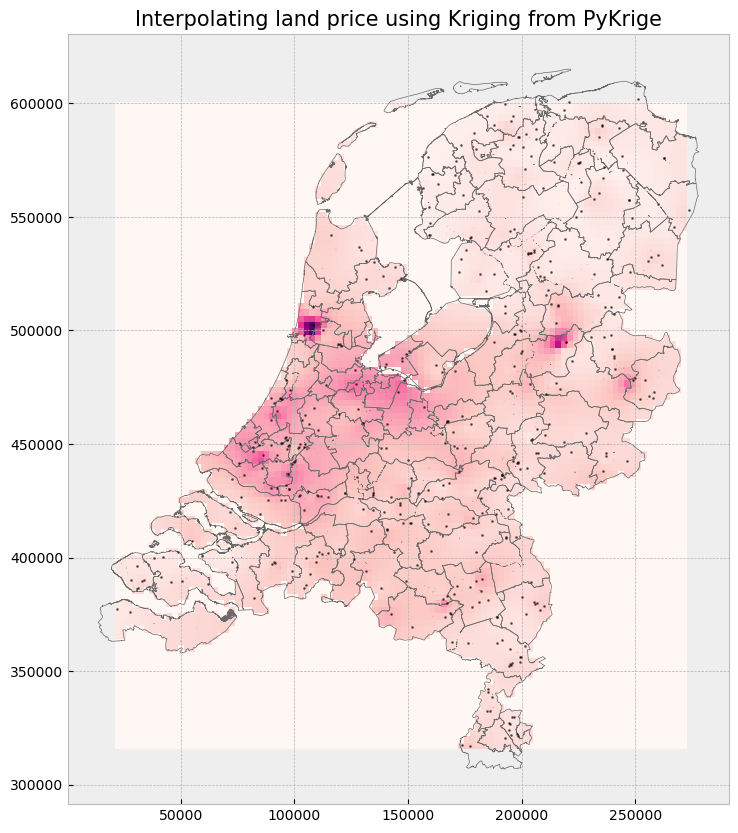

In [37]:
# may be one of the following: linear, power, gaussian, spherical, exponential, hole-effect
variogramModel = "exponential" # exponential leads to highest r-value

# Create a 100 by 100 grid
# Horizontal and vertical cell counts should be the same
XX_pk_krig = np.linspace(min_x_landPrice, max_x_landPrice, 100)
YY_pk_krig = np.linspace(min_y_landPrice, max_y_landPrice, 100)

# Generate ordinary kriging object
OK = OrdinaryKriging(
    np.array(x_landPrice), # x (array_like) – X-coordinates of data points
    np.array(y_landPrice), # y (array_like) – Y-coordinates of data points
    value_landPrice, # z (array-like) – Values at data points
    variogram_model = variogramModel,
    verbose = False,
    enable_plotting = False,
    coordinates_type = "euclidean",
)

Z_pk_krig, sigma_squared_p_krig = OK.execute(
    "grid", # Specifies how to treat input kriging points. Specifying ‘grid’ treats xpoints and 
    # ypoints as two arrays of x and y coordinates that define a rectangular grid
    XX_pk_krig, # x coordinates of grid
    YY_pk_krig # y coordinates of grid 
)

rasterPath = "results/landPrice_pk_kriging_{}.tif".format(variogramModel)

# Export raster
export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x_landPrice, max_x = max_x_landPrice, min_y = min_y_landPrice, max_y = max_y_landPrice,
                  proj = 'EPSG:28992', filename = rasterPath)

# Open raster
raster_pk = rasterio.open(rasterPath)


# Create polygon with extent of raster
poly_shapely = box(*raster_pk.bounds)

# Create a dictionary with needed attributes and required geometry column
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

# Convert shapely object to a GeoDataFrame
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = 'EPSG:28992')

# Create copy of test dataset
# landPrice_withZeros = ibis[['MX_VPRIJS', 'geometry']]
landPrice_krig = landPrice.copy()

# Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
landPrice_krig = landPrice_krig[landPrice_krig.within(raster_pk_extent.geometry.values[0])]

# Create list of XY coordinate pairs for the test points that fall within raster extent polygon
coords_landPrice_krig = [list(xy) for xy in zip(landPrice_krig["geometry"].x, landPrice_krig["geometry"].y)]

# Extract raster value at each test point and add the values to the GeoDataFrame
landPrice_krig["VALUE_Predict"] = [x[0] for x in raster_pk.sample(coords_landPrice_krig)]

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(landPrice_krig.MX_VPRIJS, landPrice_krig.VALUE_Predict)
print("PyKrige Kriging out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))

# Display attribute table
print("\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method")
display(landPrice_krig.head(2))


# Mask raster to counties shape
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, nl.geometry.values, crop = True)

# Stylize plots
plt.style.use('bmh')

# Plot data
fig, ax = plt.subplots(1, figsize = (10, 10))
show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = "RdPu")
ax.plot(x_landPrice, y_landPrice, 'k.', markersize = 2, alpha = 0.5)
nl.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

# Set title
ax.set_title('Interpolating land price using Kriging from PyKrige', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()

raster_pk.close()

In [51]:
# apply the raster created from spatial interpolation onto zero values of ibis dataset
# Open raster
raster_pk = rasterio.open(rasterPath)
poly_shapely = box(*raster_pk.bounds)
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = 'EPSG:28992')

# Create copy of ibis dataset with zeros
landPrice_krig = ibis.copy()
landPrice_krig = landPrice_krig[['RIN_NUMMER', 'MAX_MILIEU', 'geometry']]

# Extract raster value at each test point and add the values to the GeoDataFrame
landPrice_krig = landPrice_krig[landPrice_krig.within(raster_pk_extent.geometry.values[0])]
coords_landPrice_krig = [list(xy) for xy in zip(landPrice_krig["geometry"].x, landPrice_krig["geometry"].y)]
landPrice_krig["VALUE_Predict"] = [x[0] for x in raster_pk.sample(coords_landPrice_krig)]

# closer raster
raster_pk.close()

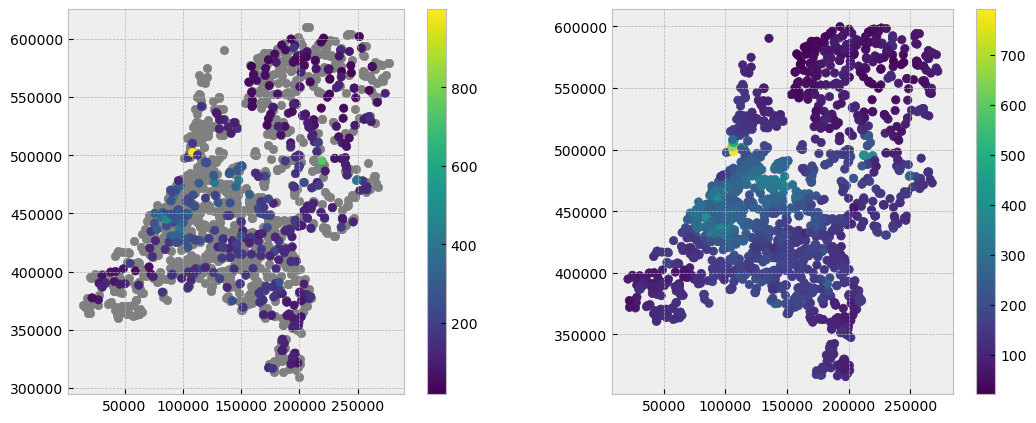

In [52]:
# plot
fig, ax = plt.subplots(1,2,figsize=(13,5))
landPrice.plot(ax=ax[0], column='MX_VPRIJS', legend=True)
zeros = ibis[ibis.MX_VPRIJS == 0]
zeros.plot(ax=ax[0], color='grey', zorder=-1)
landPrice_krig.plot(ax=ax[1], column='VALUE_Predict', legend=True)
plt.show()

In [55]:
landPrice_krig.to_file("data/ibisLandPrice_krig.shp")

C:\Users\tpytsui\AppData\Local\Temp\ipykernel_17152\1220520783.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  landPrice_krig.to_file("data/ibisLandPrice_krig.shp")


# Data collection and wrangling
Data required: 
* PBL data on future supply and demand of materials 
    * filter out wood
    * filter out private housing, and public buildings 
    * suppliers within 10-20km, customers at provincial scale 
* CBS data on demographics
    * close to high population density
* OSM data on transportation network
    * select road network
    * should be close to public transport stations 
* BAG data on building sizes and heights 
    * select buildings between 1200-1500sqm 
* Copernicus 
    * industrial areas right next to residential 
* Google Maps API, LISA 
    * near hardware stores or thrift stores 

In [24]:
# read PBL data
readDemand = gpd.read_file('../_bigData/pblUrbanMiningModels/shpsCleaned/demand_NL.shp')
readSupply = gpd.read_file('../_bigData/pblUrbanMiningModels/shpsCleaned/supply_NL.shp')

KeyboardInterrupt: 

In [ ]:
supply = readSupply[readSupply['class'].isin(['appartement', 'overheid'])][['wood', 'totKg', 'geometry']]
demand = readDemand[['wood', 'totKg', 'geometry']]
demand.head()

In [ ]:
demand.head()

In [ ]:
# read OSM data 
nodes = gpd.read_file('data/roads/nl_nodes.shp')
edges = gpd.read_file('data/roads/nl_edges.shp')

In [ ]:
# read cbs data 
cbsPc4 = gpd.read_file('../_bigData/cbs_popData/CBS_pc4_2020_v1.shp')

In [ ]:
cbsPc4.columns

Alternative sources for landuse: 
* OSM data, see [paper converting OSM data to landuse map](https://pure.iiasa.ac.at/id/eprint/13152/1/An%20automated%20methodology%20for%20converting%20OSM%20data%20into%20a%20landuse%20cover%20map.pdf)
* [LGN data](https://www.wur.nl/en/research-results/research-institutes/environmental-research/facilities-tools/kaarten-en-gis-bestanden/land-use-database-of-the-netherlands.htm), paid 

In [ ]:
# landuse
land = gpd.read_file('../_bigData/landUse/urbanAtlas_Amsterdam_2018.gpkg')